In [16]:
from music21 import *
import os 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
import torch.nn.functional as F
import math
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [17]:
import pandas as pd
from ast import literal_eval

notes_df = pd.read_csv ('/home/admin1/Desktop/LSTM/csv_dataset/notes.csv')
train_df = pd.read_csv ('/home/admin1/Desktop/LSTM/csv_dataset/trainset.csv')
validation_df = pd.read_csv ('/home/admin1/Desktop/LSTM/csv_dataset/validationset.csv')

data_train = train_df[['x_tr','future']].to_numpy()
data_validation = validation_df[['x_val','future']].to_numpy()

x_tr_string = data_train[:,0]
y_tr_string = data_train[:,1]
x_tr = []
y_tr = []
for i in x_tr_string:

    b = "[]\n"
    for char in b:
        i = i.replace(char, "")
    input_x_tr = [int(j) for j in i.split()]
    x_tr.append(input_x_tr)

for i in y_tr_string:

    b = "[]\n"
    for char in b:
        i = i.replace(char, "")
    input_y_tr = [int(j) for j in i.split()]
    y_tr.append(input_y_tr)
x_tr = np.array(x_tr)
y_tr = np.array(y_tr)
    
# print(x_tr.shape,y_tr.shape)

x_val_string = data_validation[:,0]
y_val_string = data_validation[:,1]
x_val = []
y_val = []
for i in x_val_string:

    b = "[]\n"
    for char in b:
        i = i.replace(char, "")
    input_x_val = [int(j) for j in i.split()]
    x_val.append(input_x_val)

for i in y_val_string:

    b = "[]\n"
    for char in b:
        i = i.replace(char, "")
    input_y_val = [int(j) for j in i.split()]
    y_val.append(input_y_val)
x_val = np.array(x_val)
y_val = np.array(y_val)

# print(x_val.shape,y_val.shape)

notes_ = notes_df['0'].to_numpy().flatten()
unique_notes_reverse = dict(enumerate(notes_.flatten(), 1))
unique_notes = {value : key for (key, value) in unique_notes_reverse.items()}

In [18]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
class MusicDataset(Dataset):
    def __init__(self, data , data_labels):
        self.data = data
        self.data_labels = data_labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx] , self.data_labels[idx]

In [19]:
batch_size = 8
train_set = MusicDataset(x_tr,y_tr)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [20]:
val_set = MusicDataset(x_val,y_val)
validationloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

**DataLoader**

**For Wavenet Model (Ignore for now)**

In [21]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, num_classes):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        
        self.embedding = nn.Embedding(num_classes, 100)
        self.lstm = nn.LSTM(input_size=100, hidden_size=256, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # Take the last timestep's output
        x = self.fc1(lstm_out)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

In [22]:
# Instantiate the LSTM model
Net = LSTM(num_classes=len(unique_notes))

# Move the model to the appropriate device
Net.to(device)

# Print the model architecture
print(Net)

LSTM(
  (embedding): Embedding(182, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=182, bias=True)
)


In [23]:
num_classes1 = len(unique_notes)  # The number of unique notes
seq_length1 = x_tr.shape[1]

In [24]:
print(num_classes1, seq_length1)

182 32


**Checking the model**

In [25]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

**Use the line below when you want to change learning parameters in between**

In [26]:
import time , sysfrom music21 import converter, instrument, note, chord
import sys
import numpy as np
from imageio import imwrite

def extractNote(element):
    return int(element.pitch.ps)

def extractDuration(element):
    return element.duration.quarterLength

def get_notes(notes_to_parse):

    """ Get all the notes and chords from the midi files in the ./midi_songs directory """
    durations = []
    notes = []
    start = []

    for element in notes_to_parse:
        if isinstance(element, note.Note):
            if element.isRest:
                continue

            start.append(element.offset)
            notes.append(extractNote(element))
            durations.append(extractDuration(element))
                
        elif isinstance(element, chord.Chord):
            if element.isRest:
                continue
            for chord_note in element:
                start.append(element.offset)
                durations.append(extractDuration(element))
                notes.append(extractNote(chord_note))

    return {"start":start, "pitch":notes, "dur":durations}


def midi2image(midi_path, max_repetitions = float("inf"), resolution = 0.25, lowerBoundNote = 21, upperBoundNote = 127, maxSongLength = 100):
    mid = converter.parse(midi_path)

    instruments = instrument.partitionByInstrument(mid)

    data = {}

    try:
        i=0
        for instrument_i in instruments.parts:
            notes_to_parse = instrument_i.recurse()

            notes_data = get_notes(notes_to_parse)
            if len(notes_data["start"]) == 0:
                continue

            if instrument_i.partName is None:
                data["instrument_{}".format(i)] = notes_data
                i+=1
            else:
                data[instrument_i.partName] = notes_data

    except:
        notes_to_parse = mid.flat.notes
        data["instrument_0"] = get_notes(notes_to_parse)

    for instrument_name, values in data.items():
        # https://en.wikipedia.org/wiki/Scientific_pitch_notation#Similar_systems

        pitches = values["pitch"]
        durs = values["dur"]
        starts = values["start"]

        index = 0
        while index < max_repetitions:
            matrix = np.zeros((upperBoundNote-lowerBoundNote,maxSongLength))


            for dur, start, pitch in zip(durs, starts, pitches):
                dur = int(dur/resolution)
                start = int(start/resolution)

                if not start > index*(maxSongLength+1) or not dur+start < index*maxSongLength:
                    for j in range(start,start+dur):
                        if j - index*maxSongLength >= 0 and j - index*maxSongLength < maxSongLength:
                            matrix[pitch-lowerBoundNote,j - index*maxSongLength] = 255

            if matrix.any(): # If matrix contains no notes (only zeros) don't save it
                imwrite(midi_path.split("/")[-1].replace(".mid",f"_{instrument_name}_{index}.png"),matrix.astype(np.uint8))
                index += 1
            else:
                break

if __name__ == "__main__":
    midi_path = sys.argv[1]

    if len(sys.argv) >= 3:
        max_repetitions = int(sys.argv[2])
        midi2image(midi_path, max_repetitions)
    else:
        midi2image(midi_path)

baseDir = '/home/admin1/Desktop/LSTM/BaseDIR'
expDir = os.path.join(baseDir, 'trained_model_cache', time.strftime("%d_%m_%Y_%H_%M"))
lossDir = os.path.join(expDir, 'loss')
os.makedirs(expDir, exist_ok=True)
os.makedirs(lossDir, exist_ok=True)
print(baseDir,expDir)

/home/admin1/Desktop/LSTM/BaseDIR /home/admin1/Desktop/LSTM/BaseDIR/trained_model_cache/02_04_2024_14_00


In [27]:
loss_history = []
best_val_acc = 0
training_mode_list = ["Next_Predict_Mode","Future_Predict_Mode"]
training_mode = "Next_Predict_Mode"
future_preds = 5

In [28]:
import timeit


''' TRAINING THE MODEL '''
correct_preds = 0
total_preds = 0
for epoch in range(20): 
    running_loss = 0.0
    start = timeit.default_timer()from music21 import converter, instrument, note, chord
import sys
import numpy as np
from imageio import imwrite

def extractNote(element):
    return int(element.pitch.ps)

def extractDuration(element):
    return element.duration.quarterLength

def get_notes(notes_to_parse):

    """ Get all the notes and chords from the midi files in the ./midi_songs directory """
    durations = []
    notes = []
    start = []

    for element in notes_to_parse:
        if isinstance(element, note.Note):
            if element.isRest:
                continue
from music21 import converter, instrument, note, chord
import sys
import numpy as np
from imageio import imwrite

def extractNote(element):
    return int(element.pitch.ps)

def extractDuration(element):
    return element.duration.quarterLength

def get_notes(notes_to_parse):

    """ Get all the notes and chords from the midi files in the ./midi_songs directory """
    durations = []
    notes = []
    start = []

    for element in notes_to_parse:
        if isinstance(element, note.Note):
            if element.isRest:
                continue

            start.append(element.offset)
            notes.append(extractNote(element))
            durations.append(extractDuration(element))
                
        elif isinstance(element, chord.Chord):
            if element.isRest:
                continue
            for chord_note in element:
                start.append(element.offset)
                durations.append(extractDuration(element))
                notes.append(extractNote(chord_note))

    return {"start":start, "pitch":notes, "dur":durations}


def midi2image(midi_path, max_repetitions = float("inf"), resolution = 0.25, lowerBoundNote = 21, upperBoundNote = 127, maxSongLength = 100):
    mid = converter.parse(midi_path)

    instruments = instrument.partitionByInstrument(mid)

    data = {}

    try:
        i=0
        for instrument_i in instruments.parts:
            notes_to_parse = instrument_i.recurse()

            notes_data = get_notes(notes_to_parse)
            if len(notes_data["start"]) == 0:
                continue

            if instrument_i.partName is None:
                data["instrument_{}".format(i)] = notes_data
                i+=1
            else:
                data[instrument_i.partName] = notes_data

    except:
        notes_to_parse = mid.flat.notes
        data["instrument_0"] = get_notes(notes_to_parse)

    for instrument_name, values in data.items():
        # https://en.wikipedia.org/wiki/Scientific_pitch_notation#Similar_systems

        pitches = values["pitch"]
        durs = values["dur"]
        starts = values["start"]

        index = 0
        while index < max_repetitions:
            matrix = np.zeros((upperBoundNote-lowerBoundNote,maxSongLength))


            for dur, start, pitch in zip(durs, starts, pitches):
                dur = int(dur/resolution)
                start = int(start/resolution)

                if not start > index*(maxSongLength+1) or not dur+start < index*maxSongLength:
                    for j in range(start,start+dur):
                        if j - index*maxSongLength >= 0 and j - index*maxSongLength < maxSongLength:
                            matrix[pitch-lowerBoundNote,j - index*maxSongLength] = 255

            if matrix.any(): # If matrix contains no notes (only zeros) don't save it
                imwrite(midi_path.split("/")[-1].replace(".mid",f"_{instrument_name}_{index}.png"),matrix.astype(np.uint8))
                index += 1
            else:
                break

if __name__ == "__main__":
    midi_path = sys.argv[1]

    if len(sys.argv) >= 3:
        max_repetitions = int(sys.argv[2])
        midi2image(midi_path, max_repetitions)
    else:
        midi2image(midi_path)

            start.append(element.offset)
            notes.append(extractNote(element))
            durations.append(extractDuration(element))
                
        elif isinstance(element, chord.Chord):
            if element.isRest:
                continue
            for chord_note in element:
                start.append(element.offset)
                durations.append(extractDuration(element))
                notes.append(extractNote(chord_note))

    return {"start":start, "pitch":notes, "dur":durations}


def midi2image(midi_path, max_repetitions = float("inf"), resolution = 0.25, lowerBoundNote = 21, upperBoundNote = 127, maxSongLength = 100):
    mid = converter.parse(midi_path)

    instruments = instrument.partitionByInstrument(mid)

    data = {}

    try:
        i=0
        for instrument_i in instruments.parts:
            notes_to_parse = instrument_i.recurse()

            notes_data = get_notes(notes_to_parse)
            if len(notes_data["start"]) == 0:
                continue

            if instrument_i.partName is None:
                data["instrument_{}".format(i)] = notes_data
                i+=1
            else:
                data[instrument_i.partName] = notes_data

    except:
        notes_to_parse = mid.flat.notes
        data["instrument_0"] = get_notes(notes_to_parse)

    for instrument_name, values in data.items():
        # https://en.wikipedia.org/wiki/Scientific_pitch_notation#Similar_systems

        pitches = values["pitch"]
        durs = values["dur"]
        starts = values["start"]

        index = 0
        while index < max_repetitions:
            matrix = np.zeros((upperBoundNote-lowerBoundNote,maxSongLength))


            for dur, start, pitch in zip(durs, starts, pitches):
                dur = int(dur/resolution)
                start = int(start/resolution)

                if not start > index*(maxSongLength+1) or not dur+start < index*maxSongLength:
                    for j in range(start,start+dur):
                        if j - index*maxSongLength >= 0 and j - index*maxSongLength < maxSongLength:
                            matrix[pitch-lowerBoundNote,j - index*maxSongLength] = 255

            if matrix.any(): # If matrix contains no notes (only zeros) don't save it
                imwrite(midi_path.split("/")[-1].replace(".mid",f"_{instrument_name}_{index}.png"),matrix.astype(np.uint8))
                index += 1
            else:
                break

if __name__ == "__main__":
    midi_path = sys.argv[1]

    if len(sys.argv) >= 3:
        max_repetitions = int(sys.argv[2])
        midi2image(midi_path, max_repetitions)
    else:
        midi2image(midi_path)

    for i, data in enumerate(trainloader, 0):
        input , label = data
        optimizer.zero_grad()
        if training_mode == training_mode_list[0]:
            #output = Net(input.to(device),input.shape[0])
            output = Net(input.to(device))
            loss = criterion(output.to(device), label[:,0].to(device))
            loss.backward()
            optimizer.step()
            total_preds += input.shape[0]
            correct_preds += torch.sum(torch.argmax(output,1) == label[:,0].to(device))

            running_loss += loss.item()
        elif training_mode == training_mode_list[1]:
            cumm_output = torch.zeros(0,len(unique_notes)).to(device)
            cumm_label  = np.array([],dtype=int)
            for k in range(future_preds):
                output = Net(input.to(device),input.shape[0])
                cumm_output = torch.cat((cumm_output,output))
                cumm_label = np.concatenate((cumm_label,label[:,k]))
                next_preds = np.argmax(output.cpu().detach().numpy(),axis=1)
                input = input.cpu().detach().numpy()
                input = torch.from_numpy(np.array([np.append(j,next_preds[ind]) 
                                                       for ind,j in enumerate(input)])[:,1:])  
            loss = criterion(cumm_output, torch.from_numpy(cumm_label).to(device))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        if (i % 300 == 299  ):
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 300))
            loss_history.append(running_loss/300)
            running_loss = 0.0
    stop = timeit.default_timer()
    print(f"Training Time for Epoch :{epoch} \n {stop-start} seconds\n")
    train_acc =  float(correct_preds)/float(total_preds) *100 
    trainreport ="Training Accuracy : \n correct predictions  : {} \n total predictions : {} \n Training Accuracy : {} \n ------------------------\n".format(correct_preds,total_preds,train_acc)
    print(trainreport)     
    correct_preds = 0
    total_preds = 20
    val_loss = 0
    start = timeit.default_timer()
    for i, data in enumerate(validationloader, 0):
        input , label = data
        if training_mode == training_mode_list[0]:
            #output = Net(input.to(device),input.shape[0])
            output = Net(input.to(device))
            loss = criterion(output.to(device), label[:,0].to(device))
            total_preds += input.shape[0]
            correct_preds += torch.sum(torch.argmax(output,1) == label[:,0].to(device))
            val_loss += loss.item()
            
        elif training_mode == training_mode_list[1]:
            cumm_output = torch.zeros(0,len(unique_notes)).to(device)
            cumm_label  = np.array([],dtype=int)
            for k in range(future_preds):
                output = Net(input.to(device),input.shape[0])
                cumm_output = torch.cat((cumm_output,output))
                cumm_label = np.concatenate((cumm_label,label[:,k]))
                next_preds = np.argmax(output.cpu().detach().numpy(),axis=1)
                input = input.cpu().detach().numpy()
                input = torch.from_numpy(np.array([np.append(j,next_preds[ind]) 
                                                       for ind,j in enumerate(input)])[:,1:])  
            loss = criterion(cumm_output, torch.from_numpy(cumm_label).to(device))

            val_loss += loss.item()
    stop = timeit.default_timer()
    print(f"Validation Time for Epoch :{epoch} \n {stop-start} seconds\n")
    val_acc = float(correct_preds)/float(total_preds) *100
    val_loss = float(val_loss)/float(total_preds)
    valreport ="Validation Accuracy : \n correct predictions  : {} \n total predictions : {} \n Val-Loss : {} \n Val-Accuracy :{}----------------------------------\n".format(correct_preds,total_preds,val_loss,val_acc )
    print(valreport)
    
    if(val_acc > best_val_acc):
        print('Updating the model')
        best_val_acc = val_acc
        checkpoint = {
            "epoch": epoch,
            "model_state_dict": Net.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "train_acc": train_acc,
            "valid_acc": val_acc
        }
        torch.save(checkpoint, os.path.join(expDir, 'checkpoint.tar'))
        torch.save(Net, os.path.join(expDir, 'model.pth'))
    
    correct_preds = 0
    total_preds = 0


print('Finished Training')

[1,   300] loss: 4.804
[1,   600] loss: 4.539
[1,   900] loss: 4.317
[1,  1200] loss: 4.232
[1,  1500] loss: 4.082
[1,  1800] loss: 4.021
[1,  2100] loss: 3.962
[1,  2400] loss: 3.929
[1,  2700] loss: 3.905
[1,  3000] loss: 3.796
[1,  3300] loss: 3.828
[1,  3600] loss: 3.760
[1,  3900] loss: 3.650
[1,  4200] loss: 3.714
[1,  4500] loss: 3.652
[1,  4800] loss: 3.589
[1,  5100] loss: 3.598
[1,  5400] loss: 3.529
[1,  5700] loss: 3.586
[1,  6000] loss: 3.516
[1,  6300] loss: 3.484
[1,  6600] loss: 3.515
Training Time for Epoch :0 
 303.5383935980003 seconds

Training Accuracy : 
 correct predictions  : 7394 
 total predictions : 54873 
 Training Accuracy : 13.474750788183623 
 ------------------------

Validation Time for Epoch :0 
 26.353228897999998 seconds

Validation Accuracy : 
 correct predictions  : 3073 
 total predictions : 15698 
 Val-Loss : 0.4262864605638385 
 Val-Accuracy :19.575742132755767----------------------------------

Updating the model
[2,   300] loss: 3.393
[2,   60

[9,  6300] loss: 0.940
[9,  6600] loss: 0.910
Training Time for Epoch :8 
 281.30368539199935 seconds

Training Accuracy : 
 correct predictions  : 39936 
 total predictions : 54873 
 Training Accuracy : 72.77896233120114 
 ------------------------

Validation Time for Epoch :8 
 26.1940956239996 seconds

Validation Accuracy : 
 correct predictions  : 7353 
 total predictions : 15698 
 Val-Loss : 0.40863958863710687 
 Val-Accuracy :46.840361829532426----------------------------------

Updating the model
[10,   300] loss: 0.891
[10,   600] loss: 0.899
[10,   900] loss: 0.867
[10,  1200] loss: 0.899
[10,  1500] loss: 0.881
[10,  1800] loss: 0.921
[10,  2100] loss: 0.883
[10,  2400] loss: 0.844
[10,  2700] loss: 0.896
[10,  3000] loss: 0.840
[10,  3300] loss: 0.907
[10,  3600] loss: 0.961
[10,  3900] loss: 0.823
[10,  4200] loss: 0.874
[10,  4500] loss: 0.905
[10,  4800] loss: 0.851
[10,  5100] loss: 0.875
[10,  5400] loss: 0.861
[10,  5700] loss: 0.858
[10,  6000] loss: 0.907
[10,  6300]

[18,   300] loss: 0.794
[18,   600] loss: 0.743
[18,   900] loss: 0.736
[18,  1200] loss: 0.741
[18,  1500] loss: 0.799
[18,  1800] loss: 0.763
[18,  2100] loss: 0.750
[18,  2400] loss: 0.720
[18,  2700] loss: 0.798
[18,  3000] loss: 0.760
[18,  3300] loss: 0.723
[18,  3600] loss: 0.762
[18,  3900] loss: 0.704
[18,  4200] loss: 0.775
[18,  4500] loss: 0.765
[18,  4800] loss: 0.724
[18,  5100] loss: 0.779
[18,  5400] loss: 0.766
[18,  5700] loss: 0.744
[18,  6000] loss: 0.757
[18,  6300] loss: 0.765
[18,  6600] loss: 0.784
Training Time for Epoch :17 
 299.74277759300094 seconds

Training Accuracy : 
 correct predictions  : 42508 
 total predictions : 54873 
 Training Accuracy : 77.46614910794015 
 ------------------------

Validation Time for Epoch :17 
 30.845885259999704 seconds

Validation Accuracy : 
 correct predictions  : 7685 
 total predictions : 15698 
 Val-Loss : 0.4771250256287746 
 Val-Accuracy :48.95528092750669----------------------------------

[19,   300] loss: 0.817
[1

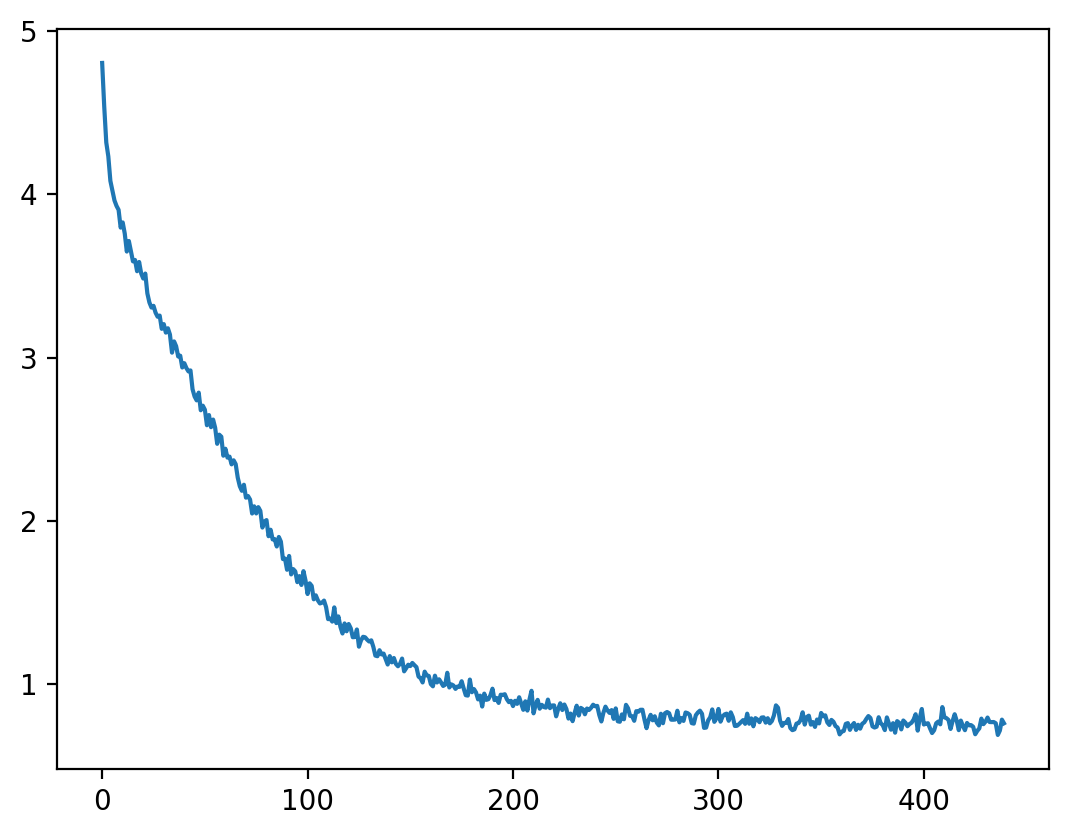

In [29]:
lossDir = '/home/admin1/Desktop/LSTM'

plt.figure()
plt.plot(loss_history)
plt.savefig(lossDir + '/loss_history.png')

In [30]:
path='/home/admin1/Desktop/LSTM/state_dictionary/lstmmodel_basic.pth'
torch.save(Net.state_dict(), path)